In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from timeseries import fetch, wrangle, BuildModel

Using TensorFlow backend.


In [2]:
# DEFINE DATA CONSTANTS
TEST_SIZE = 0.05

# DEFINE MODEL CONSTANTS
N_NODES = 100
N_LAYERS = 4
ADD_DENSE = True

# DEFINE TRAINING CONSTANTS
EPOCHS = 2

In [3]:
# specify location of time series data
file_path = '~/springboard1/capstone2/TimeSeries/data/interim/time_series.csv'

In [4]:
# read time series data
time_series_df = BuildModel.read_data(file_path)

In [5]:
# call function to format predictors and targets
predictors, targets, n_cols = BuildModel.format_predictors_and_targets(time_series_df)

In [6]:
# create scaler objects
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

In [7]:
# fit respective scalers to data
predictors = X_scaler.fit_transform(predictors)
targets = y_scaler.fit_transform(targets)

In [8]:
# split data into training set and testing set
# SHUFFLE = FALSE
X_train, X_test, y_train, y_test = train_test_split(predictors, targets, test_size=TEST_SIZE, shuffle=False, stratify=None, random_state=1)


In [9]:
# re-shape predictors for keras model
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [10]:
# DEFINE MODEL CONSTANTS
N_NODES = 100
N_LAYERS = 4
ADD_DENSE = True


# build Sequential Model
model = BuildModel.build_sequential_LSTM(N_NODES, N_LAYERS, ADD_DENSE, X_train)


# Fit the Model Exclusively with Training Data

# DEFINE TRAINING CONSTANTS
EPOCHS = 2

In [11]:
def collect_samples(num_samples=100):
    
    samples = []
    samples_collected = 0
    
    while (samples_collected < num_samples):
        
        TEST_SIZE = (np.random.randint(5, 35))/100
        print("Random TEST_SIZE: ", TEST_SIZE)
        # split data into training set and testing set
        # SHUFFLE = FALSE
        X_train, X_test, y_train, y_test = train_test_split(predictors, targets, test_size=TEST_SIZE, shuffle=False, stratify=None, random_state=1)
        # re-shape predictors for keras model
        X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
        X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

        
        
        # fit model to training data
        model.fit(X_train, y_train, epochs=EPOCHS)

        # Make Predictions
        predictions = model.predict(X_test)

        # revert scaling
        unscaled_predictions = y_scaler.inverse_transform(predictions)
        unscaled_y_test = y_scaler.inverse_transform(y_test)

        # apply exponential function
        exponential_predictions = np.exp(unscaled_predictions)
        exponential_y_test = np.exp(unscaled_y_test)

        # get accuracy
        accuracy = BuildModel.get_accuracy(exponential_y_test, exponential_predictions)
        
        if accuracy >= 50.00:
            samples.append(accuracy)
            samples_collected += 1
        print("Samples from good models collected: ", samples_collected)
        
    return samples



In [12]:
def percentile_p(arr, p):
    """return a tuple of the lower and upper bounds of a p_% confindence interval"""
    ends = 100 - p
    left = ends/2
    right = 100 - left
    return np.percentile(arr, [left, right])

In [13]:
def bootstrap_replicate_1d(data, func):
    """Draw a single bootstrap replicate"""
    return func(np.random.choice(data, size=len(data)))

In [14]:
def draw_bs_reps(data, func, size=1):
    """Draw many bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [15]:
def bootstrap_mean(samples):
    
    """ given a sample, use Bootstrap Statistics to return the distribution and the 95 % confidence interval for the mean as a tuple"""
    # compute observed mean of sample
    observed_mean = np.mean(samples)
    
    # generate 10,000 bootstrap replicates
    N_reps = 10000
    bs_replicates = draw_bs_reps(samples, np.mean, N_reps)
    
    # compute standard error of the mean 
    sem = np.std(samples) / np.sqrt(len(samples))
    
    # compute extremes of 95 percentile
    int_min, int_max = percentile_p(bs_replicates, 95)
    
    conf_min, conf_max = percentile_p(bs_replicates, 95)
    conf_range = bs_replicates[(bs_replicates >= conf_min) & (bs_replicates <= conf_max)]
    
    
    # plot distribution of bootstrap replicates
    _ , bins, _ = plt.hist(bs_replicates, bins=50, density=True, alpha=0.5)
    _ = plt.hist(conf_range, bins=bins, density=True, alpha=1, color='b')
    _ = plt.xlabel('mean')
    _ = plt.ylabel('PDF')


    _ = plt.axvline(conf_min, color='w', linestyle='-', linewidth=2.5)
    _ = plt.axvline(conf_max, color='w', linestyle='-', linewidth=2.5)
    _ = plt.axvline(np.mean(bs_replicates), color='w', linestyle=':')
    _ = plt.axvline(observed_mean, color='r', alpha=0.5, linestyle=':')

    _ = plt.title('95% Confidence Interval of the Mean')
    print(np.mean(bs_replicates).round(3), observed_mean.round(3))
    plt.show()
    
    return (bs_replicates, int_min, int_max)

In [16]:
N_SAMPLES = 30
accuracy_samples = collect_samples(N_SAMPLES)

0.2
Epoch 1/2
8082/8082 [==============================] - 5s 635us/step - loss: 0.0241
Epoch 2/2
8082/8082 [==============================] - 2s 240us/step - loss: 0.0020
Predicting change in stock price with 52.597724% accuracy
0.16
Epoch 1/2
8486/8486 [==============================] - 2s 223us/step - loss: 0.0020
Epoch 2/2
8486/8486 [==============================] - 2s 229us/step - loss: 0.0020
Predicting change in stock price with 47.062461% accuracy
0.16
Epoch 1/2
8486/8486 [==============================] - 2s 226us/step - loss: 0.0020
Epoch 2/2
8486/8486 [==============================] - 2s 255us/step - loss: 0.0020
Predicting change in stock price with 52.442795% accuracy
0.08
Epoch 1/2
9294/9294 [==============================] - 2s 244us/step - loss: 0.0018
Epoch 2/2
9294/9294 [==============================] - 2s 237us/step - loss: 0.0018
Predicting change in stock price with 48.949320% accuracy
0.1
Epoch 1/2
9092/9092 [==============================] - 2s 231us/step - lo

9193/9193 [==============================] - 3s 295us/step - loss: 0.0018
Predicting change in stock price with 47.692308% accuracy
0.17
Epoch 1/2
8385/8385 [==============================] - 2s 281us/step - loss: 0.0019
Epoch 2/2
8385/8385 [==============================] - 3s 350us/step - loss: 0.0019
Predicting change in stock price with 52.444703% accuracy
0.3
Epoch 1/2
7072/7072 [==============================] - 2s 339us/step - loss: 0.0015
Epoch 2/2
7072/7072 [==============================] - 2s 341us/step - loss: 0.0015
Predicting change in stock price with 51.435170% accuracy
0.32
Epoch 1/2
6870/6870 [==============================] - 2s 338us/step - loss: 0.0015
Epoch 2/2
6870/6870 [==============================] - 2s 325us/step - loss: 0.0015
Predicting change in stock price with 51.098051% accuracy
0.3
Epoch 1/2
7072/7072 [==============================] - 2s 340us/step - loss: 0.0015
Epoch 2/2
7072/7072 [==============================] - 2s 338us/step - loss: 0.0015
Pred

52.035 52.035


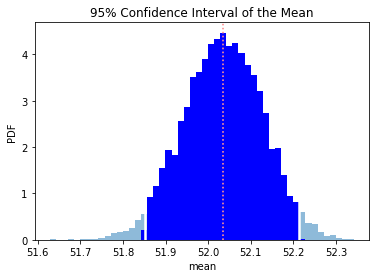

In [17]:
bootstrapping = bootstrap_mean(accuracy_samples)

In [18]:
replicates, int_min, int_max = bootstrapping
np.mean(replicates)

52.03477468541332